In [ ]:
# download data: https://drive.google.com/file/d/1U6WD6V563igKFUedzVT_hCvFeY2-tFE_/view?usp=sharing

# Transfer learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [66]:
PATH = 'cats_and_dogs_small/'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 256
IMG_SIZE = (160, 160)
BUFFER_SIZE = BATCH_SIZE*5

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [ ]:
# training data
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                              'flower_photos/',
                                              validation_split=0.2,
                                              subset="training",
                                              seed=123,
                                              image_size=(160, 160),
                                              batch_size=256)

# validation data
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                                  'flower_photos/',
                                                  validation_split=0.2,
                                                  subset="validation",
                                                  seed=123,
                                                  image_size=(160, 160),
                                                  batch_size=256)

In [67]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


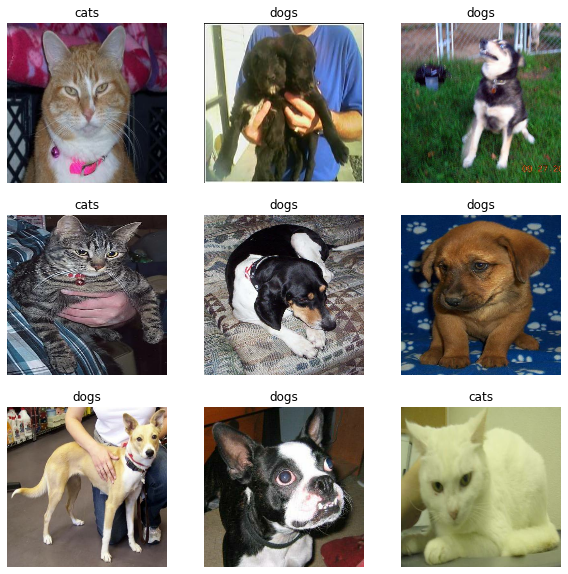

In [68]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [69]:
train_dataset = train_dataset.prefetch(buffer_size=BUFFER_SIZE)
validation_dataset = validation_dataset.prefetch(buffer_size=BUFFER_SIZE)

In [70]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

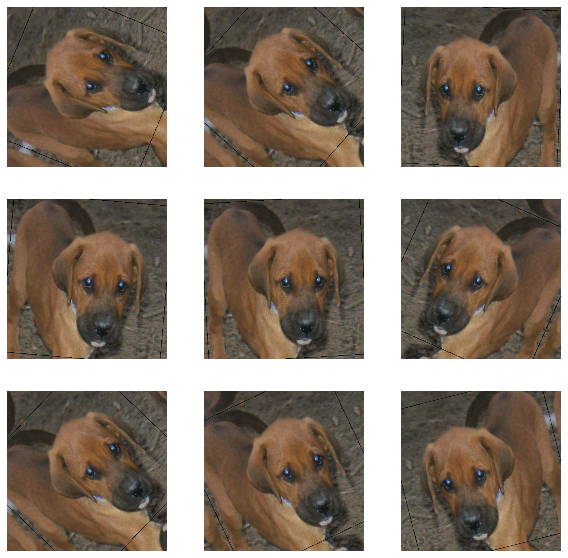

In [71]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [72]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [73]:
print(IMG_SIZE)
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)

(160, 160)
(160, 160, 3)


In [74]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [75]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(256, 5, 5, 512)


In [76]:
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [77]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(256, 512)


In [78]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(256, 1)


In [79]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [80]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [81]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice_2  [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_2 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [82]:
model.trainable_variables

[<tf.Variable 'dense_2/kernel:0' shape=(512, 1) dtype=float32, numpy=
 array([[ 5.13922349e-02],
        [-7.91122913e-02],
        [-6.26123101e-02],
        [ 8.32360610e-02],
        [-8.63686949e-02],
        [-1.03927091e-01],
        [ 7.52583519e-02],
        [ 2.79464200e-02],
        [ 6.32277057e-02],
        [-7.67138004e-02],
        [-5.12451045e-02],
        [-1.05269119e-01],
        [-1.04850754e-02],
        [-8.55391324e-02],
        [-4.39312309e-03],
        [-8.76064748e-02],
        [ 6.78578392e-02],
        [ 1.01713561e-01],
        [-2.60926783e-02],
        [ 9.71329212e-03],
        [ 7.64014199e-02],
        [ 8.02944079e-02],
        [-2.42423937e-02],
        [ 3.66293713e-02],
        [ 5.13745174e-02],
        [-8.88299942e-02],
        [ 2.29998454e-02],
        [-5.89091033e-02],
        [-5.29273562e-02],
        [-7.76002407e-02],
        [ 8.89379457e-02],
        [-1.46042034e-02],
        [-3.96819860e-02],
        [-1.74271315e-02],
        [-6.

In [83]:
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

4/4 [==============================] - 1s 155ms/step - loss: 6.0764 - accuracy: 0.5070
initial loss: 6.08
initial accuracy: 0.51


In [84]:
history = model.fit(train_dataset,
                    epochs=150,
                    validation_data=validation_dataset)

Epoch 1/150
8/8 [==============================] - 3s 373ms/step - loss: 4.6806 - accuracy: 0.4975 - val_loss: 5.4887 - val_accuracy: 0.4950
Epoch 2/150
8/8 [==============================] - 3s 370ms/step - loss: 4.3809 - accuracy: 0.5055 - val_loss: 4.9823 - val_accuracy: 0.4950
Epoch 3/150
8/8 [==============================] - 3s 370ms/step - loss: 3.9977 - accuracy: 0.5020 - val_loss: 4.5411 - val_accuracy: 0.4960
Epoch 4/150
8/8 [==============================] - 3s 374ms/step - loss: 3.7282 - accuracy: 0.5250 - val_loss: 4.1678 - val_accuracy: 0.4870
Epoch 5/150
8/8 [==============================] - 3s 372ms/step - loss: 3.5523 - accuracy: 0.5155 - val_loss: 3.8892 - val_accuracy: 0.4890
Epoch 6/150
8/8 [==============================] - 3s 373ms/step - loss: 3.5556 - accuracy: 0.5230 - val_loss: 3.6599 - val_accuracy: 0.4880
Epoch 7/150
8/8 [==============================] - 3s 373ms/step - loss: 3.3491 - accuracy: 0.5335 - val_loss: 3.4670 - val_accuracy: 0.5080
Epoch 8/150
8

Epoch 59/150
8/8 [==============================] - 3s 376ms/step - loss: 1.0974 - accuracy: 0.7645 - val_loss: 0.6964 - val_accuracy: 0.8450
Epoch 60/150
8/8 [==============================] - 3s 377ms/step - loss: 1.1584 - accuracy: 0.7650 - val_loss: 0.6809 - val_accuracy: 0.8540
Epoch 61/150
8/8 [==============================] - 3s 374ms/step - loss: 1.1335 - accuracy: 0.7685 - val_loss: 0.6619 - val_accuracy: 0.8630
Epoch 62/150
8/8 [==============================] - 3s 376ms/step - loss: 1.0683 - accuracy: 0.7770 - val_loss: 0.6498 - val_accuracy: 0.8650
Epoch 63/150
8/8 [==============================] - 3s 378ms/step - loss: 1.0204 - accuracy: 0.7915 - val_loss: 0.6389 - val_accuracy: 0.8670
Epoch 64/150
8/8 [==============================] - 3s 375ms/step - loss: 0.9843 - accuracy: 0.7830 - val_loss: 0.6249 - val_accuracy: 0.8700
Epoch 65/150
8/8 [==============================] - 3s 378ms/step - loss: 1.0834 - accuracy: 0.7785 - val_loss: 0.6138 - val_accuracy: 0.8720
Epoch 

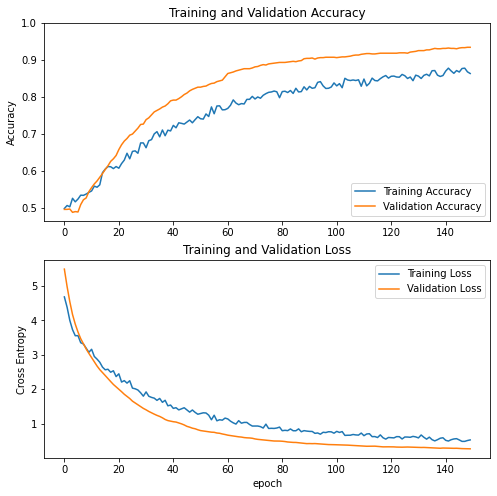

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()